# GitHub Repository Metric Analysis

In this notebook, we will analyze the GitHub data collected for the repositories mentioned in [sigs.yaml](https://github.com/open-services-group/community/blob/main/sigs.yaml) and derive some basic metrics such as number of issues/PR open, number of issues/PR closed, mean time to close PRs/issues etc.

This notebook will serve as a template notebook to analyze different GitHub repositories so that it can be easily executed in automation as part of our metrics processing pipeline. The notebook can be executed in parallel for different repos by passing as an argument the GitHub repository for which we would like to analyze and calculate metrics.

(Related issues: [Issue 1](https://github.com/open-services-group/metrics/issues/19))

In [1]:
import os
import datetime as dt
import numpy as np
from dotenv import find_dotenv, load_dotenv
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

True

In [2]:
## Create a .env file on your local with the correct configs
repo_slug = os.getenv("REPO_SLUG")
GITHUB_ACCESS_TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")

In [3]:
repo_slug

'os-climate/aicoe-osc-demo'

In [4]:
# Note: The GitHub access token needs to be exported before importing the srcopmetrics package (current bug)
from srcopsmetrics.entities.issue import Issue  # noqa: E402
from srcopsmetrics.entities.pull_request import PullRequest  # noqa: E402

In [5]:
# Gather the data
!python -m srcopsmetrics.cli -clr os-climate/aicoe-osc-demo -e Issue,PullRequest

INFO:srcopsmetrics.github_knowledge:Overall repositories found: 1
INFO:srcopsmetrics.bot_knowledge:######################## Analysing os-climate/aicoe-osc-demo ########################

INFO:srcopsmetrics.bot_knowledge:########################
INFO:srcopsmetrics.bot_knowledge:Detected entities:
CodeFrequency # Commit # DependencyUpdate # Fork # Issue # IssueEvent # KebechetUpdateManager # License # PullRequest # PullRequestDiscussion # ReadMe # Release # Stargazer # TrafficClones # TrafficPaths # TrafficPaths # TrafficReferrers # TrafficClones # TrafficViews
INFO:srcopsmetrics.bot_knowledge:########################
INFO:srcopsmetrics.bot_knowledge:Issue inspection
INFO:srcopsmetrics.entities.tools.storage:Loading knowledge locally
INFO:srcopsmetrics.entities.tools.storage:Data from file %s loaded
INFO:srcopsmetrics.entities.interface:Found previous Issue knowledge for os-climate/aicoe-osc-demo with 77 records
INFO:srcopsmetrics.iterator:-------------Issue Analysis-------------
INFO:src

## Issue Metrics

Now, lets fetch the issues for the repository and derive some metrics.

In [6]:
issue = Issue(repo_slug)
issue_df = issue.load_previous_knowledge(is_local=True)
issue_df.head()

,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
id,,,,,,,,
132,Rerun NLP demo on the new cluster,The new dev cluster with a bigger GPU is up ([...,Shreyanand,2022-02-24 16:12:24,None,NaT,{},{}
131,Use physical-landing bucket for NLP demo,"As an effort to decouple data owned by Trino, ...",Shreyanand,2022-02-24 15:57:35,None,NaT,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{}
128,Prepare GPU image for training teacher network...,**Is your feature request related to a problem...,pacospace,2022-02-10 16:16:08,erikerlandson,2022-02-17 16:09:37,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{'pacospace': 8}
127,Value Error related to S3 in demo2 notebook,Value Error related to S3 at Import in when ru...,andraNew,2022-01-07 16:17:07,andraNew,2022-01-13 11:27:54,"{'bug': {'color': 'd73a4a', 'labeled_at': 1641...","{'andraNew': 123, 'erikerlandson': 90, 'chauha..."
125,Create Jupyterbook,Add _toc.yaml and _config.yml for the repo and...,oindrillac,2021-12-17 13:09:41,oindrillac,2021-12-20 13:23:13,{},{}


In [7]:
issues_df = issue_df.reset_index()

In [8]:
issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
0,132,Rerun NLP demo on the new cluster,The new dev cluster with a bigger GPU is up ([...,Shreyanand,2022-02-24 16:12:24,None,NaT,{},{}
1,131,Use physical-landing bucket for NLP demo,"As an effort to decouple data owned by Trino, ...",Shreyanand,2022-02-24 15:57:35,None,NaT,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{}
2,128,Prepare GPU image for training teacher network...,**Is your feature request related to a problem...,pacospace,2022-02-10 16:16:08,erikerlandson,2022-02-17 16:09:37,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{'pacospace': 8}
3,127,Value Error related to S3 in demo2 notebook,Value Error related to S3 at Import in when ru...,andraNew,2022-01-07 16:17:07,andraNew,2022-01-13 11:27:54,"{'bug': {'color': 'd73a4a', 'labeled_at': 1641...","{'andraNew': 123, 'erikerlandson': 90, 'chauha..."
4,125,Create Jupyterbook,Add _toc.yaml and _config.yml for the repo and...,oindrillac,2021-12-17 13:09:41,oindrillac,2021-12-20 13:23:13,{},{}


### Number of issues created over time

In [9]:
# Let's find the number of issues created daily
issues_created_daily = (
    issues_df["created_at"].groupby(issues_df.created_at.dt.to_period("D")).agg("count")
)

In [10]:
issues_created_daily.head()

created_at
2021-09-13    9
2021-09-16    1
2021-09-17    2
2021-09-21    2
2021-09-22    1
Freq: D, Name: created_at, dtype: int64

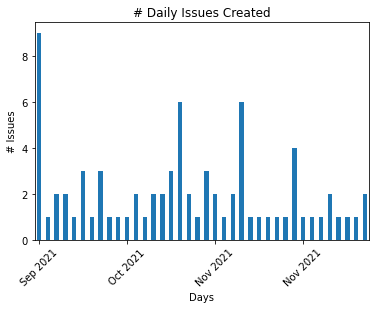

In [11]:
issues_created_daily.plot.bar()

plt.xlabel("Days")
locs, labels = plt.xticks()
N = 10
plt.xticks(locs[::N], issues_created_daily.index[::N].strftime("%b %Y"))
plt.xticks(rotation=45)
plt.ylabel("# Issues")
plt.title("# Daily Issues Created")
plt.show()

### Number of open issues

In [12]:
num_open_issues = issues_df["closed_at"].isna().sum()
num_open_issues

19

### Number of closed issues

In [13]:
num_close_issues = issues_df["closed_at"].notnull().sum()
num_close_issues

58

### Mean time to close issues

In [14]:
# Calculate the time taken to close an issue
issues_df["time_to_close"] = issues_df.closed_at - issues_df.created_at
issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions,time_to_close
0,132,Rerun NLP demo on the new cluster,The new dev cluster with a bigger GPU is up ([...,Shreyanand,2022-02-24 16:12:24,None,NaT,{},{},NaT
1,131,Use physical-landing bucket for NLP demo,"As an effort to decouple data owned by Trino, ...",Shreyanand,2022-02-24 15:57:35,None,NaT,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{},NaT
2,128,Prepare GPU image for training teacher network...,**Is your feature request related to a problem...,pacospace,2022-02-10 16:16:08,erikerlandson,2022-02-17 16:09:37,"{'enhancement': {'color': 'a2eeef', 'labeled_a...",{'pacospace': 8},6 days 23:53:29
3,127,Value Error related to S3 in demo2 notebook,Value Error related to S3 at Import in when ru...,andraNew,2022-01-07 16:17:07,andraNew,2022-01-13 11:27:54,"{'bug': {'color': 'd73a4a', 'labeled_at': 1641...","{'andraNew': 123, 'erikerlandson': 90, 'chauha...",5 days 19:10:47
4,125,Create Jupyterbook,Add _toc.yaml and _config.yml for the repo and...,oindrillac,2021-12-17 13:09:41,oindrillac,2021-12-20 13:23:13,{},{},3 days 00:13:32


Now let's find out the median time taken to close issues grouped by month.

In [15]:
issues_closed_monthly = (
    issues_df["time_to_close"]
    .groupby(issues_df.created_at.dt.to_period("M"))
    .agg("median")
)

In [16]:
issues_closed_monthly.head()

created_at
2021-09    8 days 22:47:16
2021-10   11 days 19:38:43
2021-11    5 days 10:04:41
2021-12                NaT
2022-01    5 days 19:10:47
Freq: M, Name: time_to_close, dtype: timedelta64[ns]

We can visualize the trend in median time to close issues by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the log of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the median time to close issues.

In [17]:
# days
issues_closed_monthly_days = issues_closed_monthly.astype("timedelta64[D]")
# hours
issues_closed_monthly_hours = issues_closed_monthly.astype("timedelta64[h]")
# minutes
issues_closed_monthly_minutes = issues_closed_monthly.astype("timedelta64[m]")
# seconds
issues_closed_monthly_seconds = issues_closed_monthly.astype("timedelta64[s]")

We will now consider the granularity level to be "days" and plot the median time to close issues grouped by months.

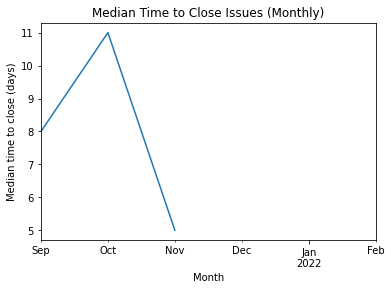

In [18]:
issues_closed_monthly_days.plot()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")
plt.show()

## PR Metrics

Now, lets fetch the PRs for the repository and derive some metrics.

In [19]:
pr = PullRequest(repo_slug)
pr_df = pr.load_previous_knowledge(is_local=True)
pr_df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
id,,,,,,,,,,,,,,,,,,
130,Fix gpu manifests builds,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,2022-02-22 09:31:00,NaT,None,NaT,None,1,1,{},{},[],[d87b0a45185451072c2fef554024a273ed8985a3],[manifests/nm-gpu-training-manifests.yaml],NaT,NaT
129,Add manifests for GPU image build,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XL,pacospace,2022-02-14 11:10:27,2022-02-17 16:09:37,erikerlandson,2022-02-17 16:09:37,erikerlandson,1,9,{'pacospace': 22},"{'881638114': {'author': 'erikerlandson', 'wor...",[],[17709f8aac5533bbaa20c311a937c89384644b14],"[manifests/.sops.yaml, manifests/README.md, ma...",2022-02-14 13:36:05,2022-02-14 13:36:05
126,Updated documentation,closes #125 \r\ncloses #110 \r\n\r\nJupyterBoo...,M,oindrillac,2021-12-17 16:40:00,2021-12-20 13:23:14,oindrillac,2021-12-20 13:23:13,oindrillac,1,5,"{'oindrillac': 13, 'chauhankaranraj': 18}","{'835457435': {'author': 'aakankshaduggal', 'w...",[],[523e26606333956764986a296149ca56edf56b40],"[README.md, _config.yml, _toc.yml, notebooks/d...",2021-12-17 17:05:43,2021-12-17 21:18:59
124,Update README,This PR \r\n- updates the README to mention th...,XS,chauhankaranraj,2021-12-14 20:45:08,2021-12-15 12:57:35,MichaelClifford,2021-12-15 12:57:35,MichaelClifford,1,1,{'MichaelClifford': 1},{},[],[ad9668f096e1e5ebc5b123d1c6df4ea5ed98af5a],[notebooks/demo2/README.md],NaT,NaT
123,Use specific versions instead of latest for im...,Closes #122,S,chauhankaranraj,2021-12-09 19:05:50,2021-12-10 21:26:47,MichaelClifford,2021-12-10 21:26:47,MichaelClifford,1,3,{'MichaelClifford': 1},"{'828089083': {'author': 'oindrillac', 'words_...",[],[c0666de738d99cf9a40e2867fc8f4e51a305d086],"[Dockerfile, notebooks/demo2/inference.pipelin...",2021-12-09 19:08:17,2021-12-09 19:08:17


In [20]:
pr_df = pr_df.reset_index()

In [21]:
pr_df.head()

,id,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,130,Fix gpu manifests builds,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,2022-02-22 09:31:00,NaT,None,NaT,None,1,1,{},{},[],[d87b0a45185451072c2fef554024a273ed8985a3],[manifests/nm-gpu-training-manifests.yaml],NaT,NaT
1,129,Add manifests for GPU image build,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XL,pacospace,2022-02-14 11:10:27,2022-02-17 16:09:37,erikerlandson,2022-02-17 16:09:37,erikerlandson,1,9,{'pacospace': 22},"{'881638114': {'author': 'erikerlandson', 'wor...",[],[17709f8aac5533bbaa20c311a937c89384644b14],"[manifests/.sops.yaml, manifests/README.md, ma...",2022-02-14 13:36:05,2022-02-14 13:36:05
2,126,Updated documentation,closes #125 \r\ncloses #110 \r\n\r\nJupyterBoo...,M,oindrillac,2021-12-17 16:40:00,2021-12-20 13:23:14,oindrillac,2021-12-20 13:23:13,oindrillac,1,5,"{'oindrillac': 13, 'chauhankaranraj': 18}","{'835457435': {'author': 'aakankshaduggal', 'w...",[],[523e26606333956764986a296149ca56edf56b40],"[README.md, _config.yml, _toc.yml, notebooks/d...",2021-12-17 17:05:43,2021-12-17 21:18:59
3,124,Update README,This PR \r\n- updates the README to mention th...,XS,chauhankaranraj,2021-12-14 20:45:08,2021-12-15 12:57:35,MichaelClifford,2021-12-15 12:57:35,MichaelClifford,1,1,{'MichaelClifford': 1},{},[],[ad9668f096e1e5ebc5b123d1c6df4ea5ed98af5a],[notebooks/demo2/README.md],NaT,NaT
4,123,Use specific versions instead of latest for im...,Closes #122,S,chauhankaranraj,2021-12-09 19:05:50,2021-12-10 21:26:47,MichaelClifford,2021-12-10 21:26:47,MichaelClifford,1,3,{'MichaelClifford': 1},"{'828089083': {'author': 'oindrillac', 'words_...",[],[c0666de738d99cf9a40e2867fc8f4e51a305d086],"[Dockerfile, notebooks/demo2/inference.pipelin...",2021-12-09 19:08:17,2021-12-09 19:08:17


### Number of PRs created over time

In [22]:
# Let's find the number of PRs created daily
pr_created_daily = (
    pr_df["created_at"].groupby(pr_df.created_at.dt.to_period("D")).agg("count")
)

In [23]:
pr_created_daily.head()

created_at
2021-09-08    2
2021-09-20    2
2021-09-27    1
2021-09-29    1
2021-10-01    2
Freq: D, Name: created_at, dtype: int64

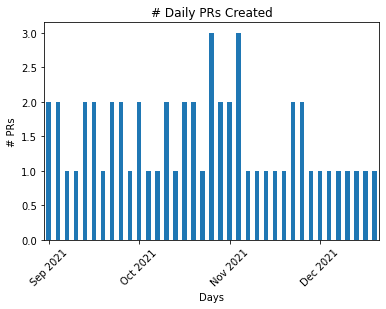

In [24]:
pr_created_daily.plot.bar()

plt.xlabel("Days")
locs, labels = plt.xticks()
N = 10
plt.xticks(locs[::N], pr_created_daily.index[::N].strftime("%b %Y"))
plt.xticks(rotation=45)
plt.ylabel("# PRs")
plt.title("# Daily PRs Created")
plt.show()

### Number of open PRs

In [25]:
num_open_prs = pr_df["closed_at"].isna().sum()
num_open_prs

3

### Number of closed PRs

In [26]:
num_close_prs = pr_df["closed_at"].notnull().sum()
num_close_prs

52

### Ratio of opened to closed PRs over the last 90 days (quarter) 

In [27]:
num_open_prs_90d = len(
    pr_df[pr_df["created_at"] > (dt.datetime.now() - dt.timedelta(days=90))]
)
num_closed_prs_90d = len(
    pr_df[pr_df["closed_at"] > (dt.datetime.now() - dt.timedelta(days=90))]
)
print("Number of open PRs:", num_open_prs_90d)
print("Number of closed PRs:", num_closed_prs_90d)

ratio = num_open_prs_90d / num_closed_prs_90d
print("Ratio of open to closed PRs over last 90 days:", ratio)

Number of open PRs: 7
Number of closed PRs: 7
Ratio of open to closed PRs over last 90 days: 1.0


A ratio of 1 indicates that we have managed to close and review all the PRs that were created in the past 90 days. Hence, we should always strive for a ratio of 1.

### Mean time to close PRs

In [28]:
# Calculate the time taken to close a PR
pr_df["time_to_close"] = pr_df.closed_at - pr_df.created_at
pr_df.head()

,id,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,time_to_close
0,130,Fix gpu manifests builds,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,2022-02-22 09:31:00,NaT,None,NaT,None,1,1,{},{},[],[d87b0a45185451072c2fef554024a273ed8985a3],[manifests/nm-gpu-training-manifests.yaml],NaT,NaT,NaT
1,129,Add manifests for GPU image build,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XL,pacospace,2022-02-14 11:10:27,2022-02-17 16:09:37,erikerlandson,2022-02-17 16:09:37,erikerlandson,1,9,{'pacospace': 22},"{'881638114': {'author': 'erikerlandson', 'wor...",[],[17709f8aac5533bbaa20c311a937c89384644b14],"[manifests/.sops.yaml, manifests/README.md, ma...",2022-02-14 13:36:05,2022-02-14 13:36:05,3 days 04:59:10
2,126,Updated documentation,closes #125 \r\ncloses #110 \r\n\r\nJupyterBoo...,M,oindrillac,2021-12-17 16:40:00,2021-12-20 13:23:14,oindrillac,2021-12-20 13:23:13,oindrillac,1,5,"{'oindrillac': 13, 'chauhankaranraj': 18}","{'835457435': {'author': 'aakankshaduggal', 'w...",[],[523e26606333956764986a296149ca56edf56b40],"[README.md, _config.yml, _toc.yml, notebooks/d...",2021-12-17 17:05:43,2021-12-17 21:18:59,2 days 20:43:14
3,124,Update README,This PR \r\n- updates the README to mention th...,XS,chauhankaranraj,2021-12-14 20:45:08,2021-12-15 12:57:35,MichaelClifford,2021-12-15 12:57:35,MichaelClifford,1,1,{'MichaelClifford': 1},{},[],[ad9668f096e1e5ebc5b123d1c6df4ea5ed98af5a],[notebooks/demo2/README.md],NaT,NaT,0 days 16:12:27
4,123,Use specific versions instead of latest for im...,Closes #122,S,chauhankaranraj,2021-12-09 19:05:50,2021-12-10 21:26:47,MichaelClifford,2021-12-10 21:26:47,MichaelClifford,1,3,{'MichaelClifford': 1},"{'828089083': {'author': 'oindrillac', 'words_...",[],[c0666de738d99cf9a40e2867fc8f4e51a305d086],"[Dockerfile, notebooks/demo2/inference.pipelin...",2021-12-09 19:08:17,2021-12-09 19:08:17,1 days 02:20:57


Now let's find out the median time taken to close PRs grouped by month.

In [29]:
prs_closed_monthly = (
    pr_df["time_to_close"].groupby(pr_df.created_at.dt.to_period("M")).agg("median")
)
prs_closed_monthly

created_at
2021-09            0 days 22:06:07.500000
2021-10                   0 days 19:59:33
2021-11                   0 days 12:40:38
2021-12                   1 days 02:20:57
2022-02   -53375 days +14:35:56.572612096
Freq: M, Name: time_to_close, dtype: timedelta64[ns]

We can visualize the trend in median time to close PRs by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the log of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the median time to close PRs.

In [30]:
# days
prs_closed_monthly_days = prs_closed_monthly.astype("timedelta64[D]")
# hours
prs_closed_monthly_hours = prs_closed_monthly.astype("timedelta64[h]")
# minutes
prs_closed_monthly_minutes = prs_closed_monthly.astype("timedelta64[m]")
# seconds
prs_closed_monthly_seconds = prs_closed_monthly.astype("timedelta64[s]")

We can now proceed to normalizing the values

In [31]:
prs_closed_monthly_days_norm = np.log(prs_closed_monthly_days)
prs_closed_monthly_hours_norm = np.log(prs_closed_monthly_hours)
prs_closed_monthly_minutes_norm = np.log(prs_closed_monthly_minutes)
prs_closed_monthly_seconds_norm = np.log(prs_closed_monthly_seconds)

In [32]:
prs_closed_monthly_hours_norm

created_at
2021-09    3.091042
2021-10    2.944439
2021-11    2.484907
2021-12    3.258097
2022-02         NaN
Freq: M, Name: time_to_close, dtype: float64

We will now consider the granularity level to be "hours" and plot the median time to close PRs grouped by months.

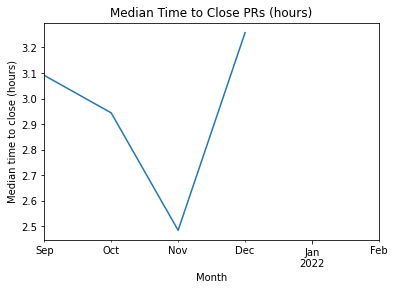

In [33]:
prs_closed_monthly_hours_norm.plot()
plt.xlabel("Month")
plt.ylabel("Median time to close (hours)")
plt.title("Median Time to Close PRs (hours)")
plt.show()